
# Changes to be made

2. Different scales need to be used at different depths of the image. 
3. Normalization of image. - What is Normalization of Image? as we are using the features like, Color Histogram,    bin spatial and the HOG Features. 
4. Grayscale image - I don't think this is necessary as the whole image is converted into a different color space. 

In [1]:
import os
import numpy as np
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog

In [189]:
# # Loading the dataset
# Scars1 = glob.glob('vehicles_smallset/cars1/*.jpeg')
# Scars2 = glob.glob('vehicles_smallset/cars2/*.jpeg')
# Scars3 = glob.glob('vehicles_smallset/cars3/*.jpeg')

# Snotcars1 = glob.glob('non-vehicles_smallset/notcars1/*.jpeg')
# Snotcars2 = glob.glob('non-vehicles_smallset/notcars2/*.jpeg')
# Snotcars3 = glob.glob('non-vehicles_smallset/notcars3/*.jpeg')

# Scars = Scars1 + Scars2 + Scars3
# Snotcars = Snotcars1 + Snotcars2 + Snotcars3
# print (len(Scars))
# print (len(Snotcars))

In [190]:
# Loading the dataset
cars1 = glob.glob('dataset/vehicles/GTI_Far/*.png')
cars2 = glob.glob('dataset/vehicles/GTI_Left/*.png')
cars3 = glob.glob('dataset/vehicles/GTI_MiddleClose/*.png')
cars4 = glob.glob('dataset/vehicles/GTI_Right/*.png')
cars5 = glob.glob('dataset/vehicles/KITTI_extracted/*.png')

notcars1 = glob.glob('dataset/non-vehicles/Extras/*.png')
notcars2 = glob.glob('dataset/non-vehicles/GTI/*.png')

Scars = cars1 + cars2 + cars3 + cars4 + cars5 
Snotcars = notcars1 + notcars2

print(len(Scars))
print(len(Snotcars))

8792
8968


In [191]:
def bin_spatial(img, size=( 32, 32 )):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    numpy_array = np.hstack ((color1, color2, color3))
    return numpy_array
    
def color_hist(img, nbins=32, bins_range=( 0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features
    
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector = feature_vec)
        return features, hog_image
    
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector = feature_vec)
        return features
    
    
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8 , cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    features = []
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        image = image.astype(np.float32)/255.0
        
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                
        else: 
            feature_image = np.copy(image)      
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size = spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append( get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)   
                
            else:
                hog_features = get_hog_features( feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                print (hog_features.shape)
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))
        
    return features


In [192]:
color_space = 'YUV'
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (16 ,16)
hist_bins = 16

spatial_feat = False
hist_feat = False
hog_feat = True
y_start_stop = [None,None]

car_features    = extract_features(Scars, color_space = color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("Car features Obtained")

notcar_features = extract_features(Snotcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("Not car features Obtained")


Car features Obtained
Not car features Obtained


In [193]:
## Finding the best parameters code here. 
from sklearn import svm
from sklearn.svm import LinearSVC

orients_list = [ 8, 9, 10, 11, 12]
color_spaces = ['YUV','LUV','YCrCb']

for color in color_spaces:
    for orient in orients_list:
        
        pix_per_cell = 8
        cell_per_block = 2
        hog_channel = 'ALL'
        spatial_size = (16 ,16)
        hist_bins = 16

        spatial_feat = False
        hist_feat = False
        hog_feat = True
        y_start_stop = [None,None]

        car_features    = extract_features(Scars, color_space = color, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient = orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
        
        notcar_features = extract_features(Snotcars, color_space=color, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient = orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
        
        X = np.vstack((car_features, notcar_features)).astype(np.float64)   
        X_scaler = StandardScaler().fit(X)
        scaled_X = X_scaler.transform(X)
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
        
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=23)
        
        finalSvc = LinearSVC()
        finalSvc.fit( X_train , y_train )
        score = finalSvc.score( X_test, y_test )
        
        print('Orient: ',orient,' color space : ',color ,' Score: ',score)

Orient:  8  color space :  YUV  Score:  0.981137387387
Orient:  9  color space :  YUV  Score:  0.982826576577
Orient:  10  color space :  YUV  Score:  0.98536036036
Orient:  11  color space :  YUV  Score:  0.982263513514
Orient:  12  color space :  YUV  Score:  0.981981981982
Orient:  8  color space :  LUV  Score:  0.963682432432
Orient:  9  color space :  LUV  Score:  0.977759009009
Orient:  10  color space :  LUV  Score:  0.974380630631
Orient:  11  color space :  LUV  Score:  0.979448198198
Orient:  12  color space :  LUV  Score:  0.972691441441
Orient:  8  color space :  YCrCb  Score:  0.982263513514
Orient:  9  color space :  YCrCb  Score:  0.984234234234
Orient:  10  color space :  YCrCb  Score:  0.985078828829
Orient:  11  color space :  YCrCb  Score:  0.982545045045
Orient:  12  color space :  YCrCb  Score:  0.98338963964


In [61]:
from sklearn import svm
from sklearn.svm import LinearSVC

X = np.vstack((car_features, notcar_features)).astype(np.float64)   
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=23)

finalSvc = LinearSVC(C=10)
finalSvc.fit( X_train , y_train )
score = finalSvc.score( X_test, y_test )

print('The test score of the SVC is : ', score)

The test score of the SVC is :  0.982263513514


In [62]:
def add_heat (heatmap, bbox_list):
    for box in bbox_list:
        heatmap[ box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold( heatmap, threshold ):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img


In [180]:
from scipy.ndimage.measurements import label
import functools
from collections import deque

heat_history = deque(maxlen=7)

def find_cars( my_img , ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):    
    
    on_windows = []
    test_img = np.copy(my_img)
    draw_img = np.copy(my_img)
    
    luv_image = cv2.cvtColor(my_img, cv2.COLOR_RGB2YUV)
    luv_image = luv_image.astype(np.float32)/255.0    
    
    for scale in scales: 
        
#         print("The scale is: ", scale)
        img_tosearch = luv_image[ystart:ystop, :, :]
        ctrans_tosearch = img_tosearch
        window = 64
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(img_tosearch.shape[1]//scale), np.int(img_tosearch.shape[0]//scale)))
        
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
        
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 

        nfeat_per_block = orient*cell_per_block**2
        cells_per_step = 2
        
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
        hog1 = get_hog_features( ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features( ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features( ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                
                hog_feat1 = hog1[ ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window ].ravel() 
                hog_feat2 = hog2[ ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window ].ravel() 
                hog_feat3 = hog3[ ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window ].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell
                
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)
                
                test_features = X_scaler.transform((hog_features).reshape(1, -1))
                test_prediction = svc.predict(test_features)
                
                if test_prediction == 1:
                    ## The below is scaling the obtined boxes to the original image size. 
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw  = np.int(window*scale)
                    on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart)))
#                     cv2.rectangle(test_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart) , (0,0,255), 6)            
                    
#     plt.imshow(test_img)
#     plt.show()
    
    heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)
    heat = add_heat( heat, on_windows )
    
#     plt.imshow(heat)
#     plt.show()
    heat_history.append(heat)
    final_heat = sum(heat_history)
    
#     print ('Final Heat image is: ')
#     plt.imshow(final_heat)
#     plt.show()
#   print ("The type of final heat is: ", type(final_heat))
#   print("final heat shape is: ",final_heat.shape)
    
    ## Max value and Min value for the heat_history
    max_value = np.amax(final_heat)
#     print("max value is: ",max_value)
    
    min_value = np.amin(final_heat)
#     print("min value is: ",min_value)
    
    threshold = max_value*0.5
    
#     print ('Threshold value is: ',threshold)
    if threshold<30:
        threshold = 30
        
#     print ('Threshold value2 is: ',threshold)
    final_heat = apply_threshold( final_heat, threshold)
    heatmap = np.clip( final_heat , 0, 255 )
    labels = label( heatmap )
    draw_img = draw_labeled_bboxes( draw_img, labels )
#     plt.imshow(draw_img)
#     plt.show()
    return draw_img


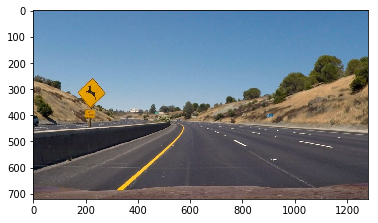

Came here


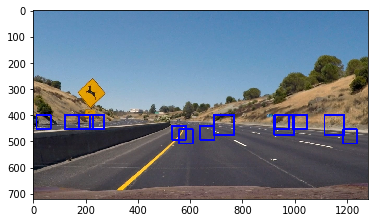

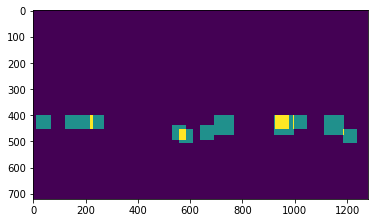

Final Heat image is: 


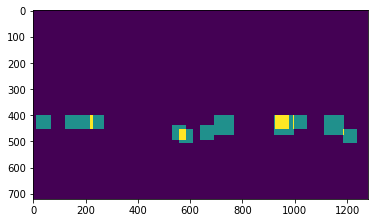

Threshold value is:  1.0
Threshold value2 is:  20
And here


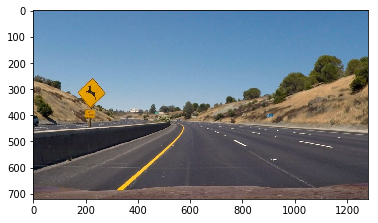

In [165]:
import time
ystart = 400
ystop  = 656
scale  = [ 0.85, 1, 1.2 , 1.5, 2, 3, 4]

image = mpimg.imread('project/test_images/test2.jpg')
plt.imshow(image)
plt.show()

print("Came here")
out_img = find_cars(image, ystart, ystop, scale, finalSvc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

print("And here")
plt.imshow(out_img)
plt.show()


In [181]:
# Testing on Videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [182]:
def process_image(image):
    ystart = 400
    ystop = 656
    scale = [ 0.85, 1, 1.2 ,1.5, 2, 3, 4]
    
    out_img = find_cars(image, ystart, ystop, scale, finalSvc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    return out_img


In [183]:
white_output = 'first8Secs.mp4'
# clip1 = VideoFileClip("project/test_video.mp4")
# clip1 = VideoFileClip("project/project_video.mp4").subclip(19,21)
clip1 = VideoFileClip("project/project_video.mp4")
white_clip = clip1.fl_image(process_image) ## NOTE: this function expects color images
%time white_clip.write_videofile(white_output, audio=True)


[MoviePy] >>>> Building video first8Secs.mp4
[MoviePy] Writing audio in first8SecsTEMP_MPY_wvf_snd.mp3



100%|██████████| 1112/1112 [00:01<00:00, 683.05it/s]

[MoviePy] Done.
[MoviePy] Writing video first8Secs.mp4



 12%|█▏        | 147/1261 [08:55<1:15:02,  4.04s/it]


 23%|██▎       | 293/1261 [18:51<1:08:29,  4.25s/it]


 35%|███▍      | 441/1261 [28:45<45:28,  3.33s/it]


 47%|████▋     | 592/1261 [37:53<47:33,  4.27s/it]


 59%|█████▉    | 743/1261 [47:54<31:50,  3.69s/it]


 71%|███████   | 894/1261 [57:34<27:10,  4.44s/it]


 82%|████████▏ | 1040/1261 [1:07:00<15:08,  4.11s/it]


 94%|█████████▍| 1183/1261 [1:16:28<04:33,  3.51s/it]


100%|█████████▉| 1260/1261 [1:21:18<00:03,  3.94s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: first8Secs.mp4 

CPU times: user 1h 16min 53s, sys: 2min 26s, total: 1h 19min 19s
Wall time: 1h 21min 21s


In [184]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))